In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from alpha import loadData
from alpha import iterate_minibatches
from alpha import saveGraph
from alpha import lrelu
from alpha import make_square
from cnn_utils import  conv_layer, fc_layer

In [3]:
import tensorflow as tf
import os, cv2, random
import numpy as np
import pandas as pd
import time, math
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from collections import OrderedDict

%matplotlib inline

In [4]:
tf.__version__

'1.12.0'

In [5]:
'''
Designing auto encoder network.
'''
graph = tf.Graph()

In [6]:
with graph.as_default():
    '''
    two placeholder to place input and output images. 
    Technically this will be same image.
    '''
    X = tf.placeholder(tf.float32,[None,64,64,3])
    Y = tf.placeholder(tf.float32,[None,64,64,3])

In [7]:
'''
Encoder network:
    This will map the input image to a euclidian space
    Name scope has added to view the network clearly on tensorboard
'''
with graph.as_default():
    with tf.name_scope('en-convolutions'):
        conv0 = tf.layers.conv2d(X,filters=4,kernel_size=(3,3),strides=(1,1),padding='SAME',use_bias=True,activation=lrelu,name='conv0')
    with tf.name_scope('en-pooling'):
        maxpool0 = tf.layers.max_pooling2d(conv0,pool_size=(2,2),strides=(2,2),name='pool0')     
    
    with tf.name_scope('en-convolutions'):
        conv1 = tf.layers.conv2d(maxpool0,filters=4,kernel_size=(3,3),strides=(1,1),padding='SAME',use_bias=True,activation=lrelu,name='conv1')
    with tf.name_scope('en-pooling'):
        maxpool1 = tf.layers.max_pooling2d(conv1,pool_size=(2,2),strides=(2,2),name='pool1')
    
    with tf.name_scope('en-convolutions'):
        conv2 = tf.layers.conv2d(maxpool1,filters=8,kernel_size=(3,3),strides=(1,1),padding='SAME',use_bias=True,activation=lrelu,name='conv2')
    with tf.name_scope('en-pooling'):
        maxpool2 = tf.layers.max_pooling2d(conv2,pool_size=(2,2),strides=(2,2),name='pool2')
    
    with tf.name_scope('en-convolutions'):
        conv3 = tf.layers.conv2d(maxpool2,filters=16,kernel_size=(3,3),strides=(1,1),padding='SAME',use_bias=True,activation=lrelu,name='conv3')
    with tf.name_scope('encoding'):
        encoded = tf.layers.average_pooling2d(conv3,pool_size=(2,2),strides=(2,2),name='encoding')

In [8]:
'''
The last tensor, 'encoded',  will be a of shape (?, 4, 4, 16), which then will be flattened to shape (, 256).
This will be the compressed representation of the input image
'''
encoded

<tf.Tensor 'encoding/encoding/AvgPool:0' shape=(?, 4, 4, 16) dtype=float32>

In [9]:
'''
Decoder network:
This will map the encodings back to image of same input shape
'''
with graph.as_default():
    with tf.name_scope('decoder'):
        upsample1 = tf.layers.conv2d_transpose(encoded,filters=16,kernel_size=3,padding='same',strides=2,name='upsample1')
        conv4 = tf.layers.conv2d(upsample1,filters=16,kernel_size=(3,3),strides=(1,1),padding='SAME',name='conv4',use_bias=True,activation=lrelu)#upsample1 #
        
        upsample2 = tf.layers.conv2d_transpose(conv4,filters=8,kernel_size=3,padding='same',strides=2,name='upsample2') 
        conv5 = tf.layers.conv2d(upsample2,filters=8,kernel_size=(3,3),strides=(1,1),name='conv5',padding='SAME',use_bias=True,activation=lrelu)#upsample2 #
        
        upsample3 = tf.layers.conv2d_transpose(conv5,filters=8,kernel_size=5,padding='same',strides=2,name='upsample3')
        conv6 = tf.layers.conv2d(upsample3,filters=4,kernel_size=(5,5),strides=(1,1),name='conv6',padding='SAME',use_bias=True,activation=lrelu)
        
        upsample4 = tf.layers.conv2d_transpose(conv6,filters=8,kernel_size=5,padding='same',strides=2,name='upsample4')
        conv7 = tf.layers.conv2d(upsample4,filters=4,kernel_size=(5,5),strides=(1,1),name='conv7',padding='SAME',use_bias=True,activation=lrelu)
        
        logits = tf.layers.conv2d(conv7,filters=3,kernel_size=(3,3),strides=(1,1),name='logits',padding='SAME',use_bias=True)
        decoded = tf.sigmoid(logits,name='recon')

In [10]:
with graph.as_default():
    '''
    Defining loss function and optimizer
    '''
    loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,labels=Y)
    lr = tf.placeholder(tf.float32, shape=[])
    cost = tf.reduce_mean(loss)
    opt = tf.train.AdamOptimizer(learning_rate=lr).minimize(cost) #optimizer
    
    summaryMerged = tf.summary.merge_all() #For tensorboard
    filename="./summary_log/run-"+time.strftime("%d%m-%H%M%S")

In [11]:

'''
Loading all the images for training.
Since this is an unsupervised problem, the task is to encode the given dataset.
So the whole concept of train/test data samples is not used

'''
train = loadData(limit=99999)
train.shape

(5000, 64, 64, 3)

In [12]:
'''
Ran 6 times 10 epochs with learning rate decay and different mini batch sizes.
Every 10 epochs, training had stopped and checked the model performance by ploting 'predicted duplicates' 
of random products and validated
'''

minibatch_size = 256
epoch = 10
learning_rate = 0.00002

with tf.Session(graph=graph) as sess:
    writer = tf.summary.FileWriter(filename, sess.graph) 
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    saver.restore(sess, tf.train.latest_checkpoint('./saved_model/'))
    for ep in range(epoch):
      avg_cost = 0
      for i, minibatch in enumerate(iterate_minibatches(train, minibatch_size)):
        batch_cost, _ = sess.run([cost, opt], feed_dict={X: minibatch,
                                                             Y: minibatch,
                                                            lr: learning_rate})
        
      print("Epoch: {}/{}...".format(ep+1, epoch), \
                  "Training loss: {:.4f}".format(batch_cost))
    saver.save(sess, "./saved_model/model")

INFO:tensorflow:Restoring parameters from ./saved_model/model
Epoch: 1/10... Training loss: 0.4858
Epoch: 2/10... Training loss: 0.4741
Epoch: 3/10... Training loss: 0.4741
Epoch: 4/10... Training loss: 0.4762
Epoch: 5/10... Training loss: 0.4764
Epoch: 6/10... Training loss: 0.4727
Epoch: 7/10... Training loss: 0.4756
Epoch: 8/10... Training loss: 0.4600
Epoch: 9/10... Training loss: 0.4600
Epoch: 10/10... Training loss: 0.4658


In [13]:
'''
Read all images; 
Calculate embeddings for each images
Append the embeddings and product index to two seperate arrays
'''
limit = 99999
DIR = './train'
IMG_SIZE = 64
embeddings = []
labels = []
with tf.Session(graph=graph) as sess:
    saver = tf.train.Saver()
    saver.restore(sess, tf.train.latest_checkpoint('./saved_model/'))
    for i, im in (enumerate(os.listdir(DIR))):     # tqdm: Professional progress bar 
        if not im.startswith('.'):
            path = os.path.join(DIR, im)
            if i >= limit: break
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
            img = img/255.0
            embeddings.append(sess.run(encoded,feed_dict={X:img.reshape((-1,64,64,3))}).reshape(-1,256))
            labels.append(int(path.split('.')[-2].split('-')[-1]))  
#             print(int(path.split('.')[-2].split('-')[-1]))
labels = np.array(labels)
embeddings = np.array(np.squeeze(embeddings))

INFO:tensorflow:Restoring parameters from ./saved_model/model


In [19]:
for op in graph2.get_operations():
     print(op.name)

Placeholder
Placeholder_1
conv0/kernel/Initializer/random_uniform/shape
conv0/kernel/Initializer/random_uniform/min
conv0/kernel/Initializer/random_uniform/max
conv0/kernel/Initializer/random_uniform/RandomUniform
conv0/kernel/Initializer/random_uniform/sub
conv0/kernel/Initializer/random_uniform/mul
conv0/kernel/Initializer/random_uniform
conv0/kernel
conv0/kernel/Assign
conv0/kernel/read
conv0/bias/Initializer/zeros
conv0/bias
conv0/bias/Assign
conv0/bias/read
en-convolutions/conv0/dilation_rate
en-convolutions/conv0/Conv2D
en-convolutions/conv0/BiasAdd
en-convolutions/conv0/mul/x
en-convolutions/conv0/mul
en-convolutions/conv0/Maximum
en-pooling/pool0/MaxPool
conv1/kernel/Initializer/random_uniform/shape
conv1/kernel/Initializer/random_uniform/min
conv1/kernel/Initializer/random_uniform/max
conv1/kernel/Initializer/random_uniform/RandomUniform
conv1/kernel/Initializer/random_uniform/sub
conv1/kernel/Initializer/random_uniform/mul
conv1/kernel/Initializer/random_uniform
conv1/kernel


gradients/en-convolutions_1/conv1/Conv2D_grad/tuple/control_dependency_1
gradients/en-pooling/pool0/MaxPool_grad/MaxPoolGrad
gradients/en-convolutions/conv0/Maximum_grad/Shape
gradients/en-convolutions/conv0/Maximum_grad/Shape_1
gradients/en-convolutions/conv0/Maximum_grad/Shape_2
gradients/en-convolutions/conv0/Maximum_grad/zeros/Const
gradients/en-convolutions/conv0/Maximum_grad/zeros
gradients/en-convolutions/conv0/Maximum_grad/GreaterEqual
gradients/en-convolutions/conv0/Maximum_grad/BroadcastGradientArgs
gradients/en-convolutions/conv0/Maximum_grad/Select
gradients/en-convolutions/conv0/Maximum_grad/Select_1
gradients/en-convolutions/conv0/Maximum_grad/Sum
gradients/en-convolutions/conv0/Maximum_grad/Reshape
gradients/en-convolutions/conv0/Maximum_grad/Sum_1
gradients/en-convolutions/conv0/Maximum_grad/Reshape_1
gradients/en-convolutions/conv0/Maximum_grad/tuple/group_deps
gradients/en-convolutions/conv0/Maximum_grad/tuple/control_dependency
gradients/en-convolutions/conv0/Maximum

In [21]:
'''
Writing the weights to pb file for prediction/serving
'''
graph2 = tf.Graph()
with tf.Session(graph=graph2) as sess:
    saver = tf.train.import_meta_graph('./saved_model/model.meta')
    input_graph_def = tf.get_default_graph().as_graph_def()
    saver.restore(sess, "./saved_model/model")
    
    output_node_names="encoding/encoding/AvgPool"
    output_graph_def = tf.graph_util.convert_variables_to_constants(sess,
                                                      input_graph_def,
                                                      output_node_names.split(","))
    output_graph="./pb/TunicsEncoder-v0.1.pb"
    with tf.gfile.GFile(output_graph, "wb") as f:
        f.write(output_graph_def.SerializeToString())

INFO:tensorflow:Restoring parameters from ./saved_model/model
INFO:tensorflow:Froze 8 variables.
INFO:tensorflow:Converted 8 variables to const ops.


In [24]:
'''
Dumping and saving  to .npy format.
Used for development purpose; had to restart notebokk several time, this method of reading is always faster.
'''
np.save('./Embeddings/embeddings.npy', embeddings)
np.save('./Embeddings/labels.npy', labels)
embeddings = np.load('./Embeddings/embeddings.npy').reshape(5000, 256)  #since 37547 items
labels = np.load('./Embeddings/labels.npy').reshape(5000,)

In [25]:
'''
Creating Dataframe with each embeddings elements as columns(total 256 columns) and coresponding labels as the index
'''
data = pd.DataFrame(embeddings)
data['labels'] = labels
data.set_index('labels', inplace=True)
data.sort_index(inplace=True)

In [26]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
labels,,,,,,,,,,,,,,,,,,,,,
0,0.348384,0.006783,0.224728,-0.053152,0.529152,0.118496,0.309686,0.545753,0.500409,-0.073672,...,0.267398,0.464303,0.480773,-0.054167,0.018225,0.049942,-0.074021,-0.012314,-0.030506,0.280367
1,0.348384,0.006783,0.224728,-0.053152,0.529152,0.118496,0.309686,0.545753,0.500409,-0.073672,...,0.267398,0.464303,0.480773,-0.054167,0.018225,0.049942,-0.074021,-0.012314,-0.030506,0.280367
2,0.316576,-0.007508,0.275680,-0.069322,0.585650,0.156816,0.325796,0.693992,0.594700,-0.077752,...,0.270742,0.422026,0.460293,-0.044719,0.008291,0.070382,-0.059784,0.002599,-0.023929,0.222184
3,0.316576,-0.007508,0.275680,-0.069322,0.585650,0.156816,0.325796,0.693992,0.594700,-0.077752,...,0.270742,0.422026,0.460293,-0.044719,0.008291,0.070382,-0.059784,0.002599,-0.023929,0.222184
4,0.317019,0.009430,0.232040,-0.057410,0.515643,0.127855,0.373448,0.576609,0.519166,-0.071267,...,0.305907,0.485301,0.523371,-0.051027,-0.014357,0.076579,-0.066585,-0.009044,-0.030204,0.234017


In [27]:
def getEmbeddings(idx):
    '''
    Calculates embedding vector given a single image
    input: index of single image to be tested
    return: Embeddings of shape (256,)
    '''
    IMG_SIZE = 64
    img = cv2.imread('./train/im-400-{}.jpg'.format(idx))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    img = img/255.0
    
    with tf.Session(graph=graph) as sess:
        saver = tf.train.Saver()
        saver.restore(sess, tf.train.latest_checkpoint('./saved_model/'))
        dist = sess.run(encoded,feed_dict={X:img.reshape((-1,64,64,3))})
    
    return np.squeeze(dist.reshape(-1,4*4*16))

In [28]:
#Reading images with index of 'scores' dataframe
def getPredictedImages(score):
    '''
    loading images with id equals to index of 'score'
    '''
    images = []
    IMG_SIZE = 200
    for idx in score.index:
        path = './train/im-400-{}.jpg'.format(idx)
        img = Image.open(path)
        img  = make_square(img)
        img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        images.append([np.array(img)])
    return np.array(images).reshape(-1, 200,200,3)

In [29]:
def getPredictions(testEmbeddings):
    '''
    input: Embeddings a single test image; shape- (256,)
    return: Dataframe contains details of top 10 similar images
    and 
    '''
    dist = (np.array(data) - testEmbeddings)**2
    dist = np.sum(dist, axis=1)
    dist = np.sqrt(dist)    
    '''
    dist : Euclidean distance between testEmbedding and embeddings of all the images. dtype: numpy array
    '''
    
    df = pd.DataFrame({'distance':dist})
    df.index = data.index
    df.sort_values('distance', ascending=True, inplace=True) 
    score = df[:10] #Taking highest 10 
    score['score'] = df.distance[:10].apply(lambda x: np.round(1-np.tanh(x)**10, 3)).values
    '''
    tanh is used to map distance to 0 to 1
    '''
    return score

In [30]:
def getTestimage(idx):
    '''
    This is for ploting the original image
    reads image from directory given index
    '''
    path = './train/im-400-{}.jpg'.format(idx)
    img = Image.open(path)
    img  = make_square(img)
    img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [31]:
def plotImages(idx, im, images, score):
    '''
    Function to plot original image and images with highest scores; 
    plots 10 images with xlabels: Score, original id and seller-name 
    '''
    fig, axes = plt.subplots(5,2, figsize = (15,25))
    fig.subplots_adjust(hspace = 0.3, wspace = 0.3)
    
    for i, ax in enumerate(axes.flat):
        if i==0:
            idX, sellerName = getinfo(idx)
            ax.imshow(im, cmap = 'binary')
            xlabel = "Original image \n id: {} \n Seller: {}".format(idX, sellerName)
            ax.set_xlabel(xlabel, fontsize = 13)
        else:    
            ax.imshow(images[i-1], cmap = 'binary')
            
            idX, sellerName = getinfo(score.index[i])
            xlabel = "score: {} \nid:{} \n Seller: {}".format(score.score.iloc[i-1], idX, sellerName)
        
            ax.set_xlabel(xlabel, fontsize = 12)
        
        #Remove axis ticks
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

In [32]:
'''
Reading two Dataframes, 'Data' and 'tunicSlice'
Data : sliced 'tunic' from original with index had reset
tunicSlice : sliced 'tunic' from original with original index
'''
Data = pd.read_csv('./Data/data.csv')
tunicSlice = pd.read_csv('./Data/tunics.csv')

def getIndex(idx):
    '''
    index of subset and original data is different.
    This function will return original index given the subset index
    '''
    pid = Data[Data.index==idx]['productId'].values[0]
    idxTunic = tunicSlice[tunicSlice.productId==pid]['index'].values[0]
    return idxTunic

def getinfo(idx):
    pid = Data[Data.index==idx]['productId'].values[0]
    idxTunic = tunicSlice[tunicSlice.productId==pid]['index'].values[0]
    return idxTunic, tunicSlice[tunicSlice['index']==idxTunic]['sellerName'].values[0]

INFO:tensorflow:Restoring parameters from ./saved_model/model


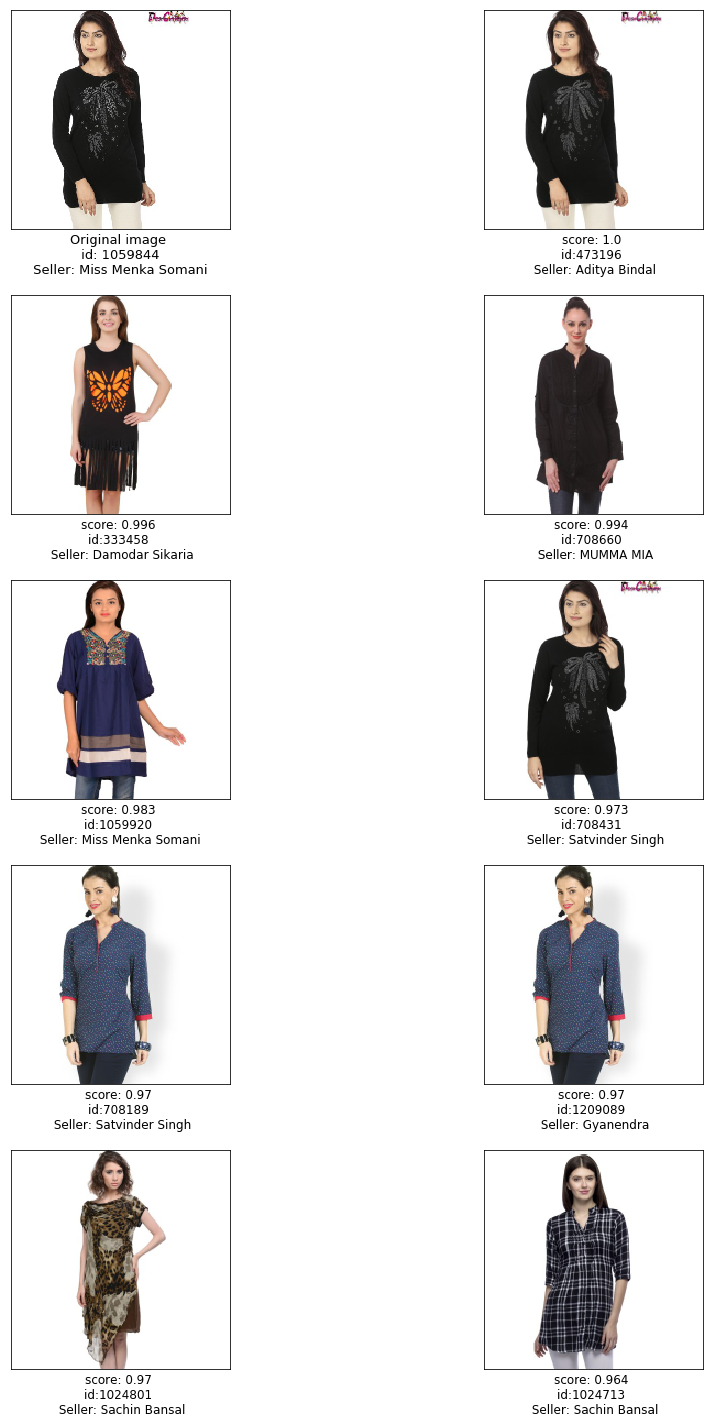

In [33]:
'''
Testing one image
'''
idx = 4534
testEmbeddings = getEmbeddings(idx)
score = getPredictions(testEmbeddings)
images =  getPredictedImages(score)
im = getTestimage(idx)
plotImages(idx, im, images, score)

INFO:tensorflow:Restoring parameters from ./saved_model/model


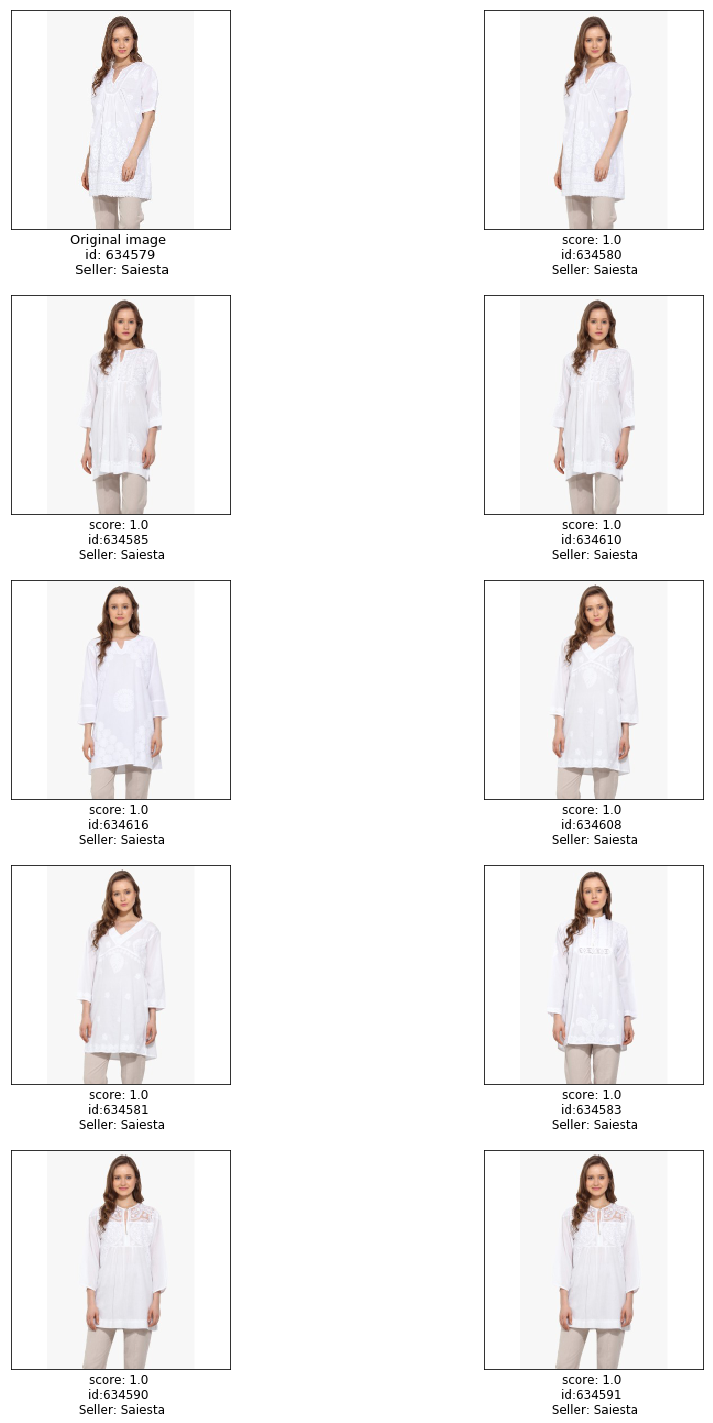

In [34]:
idx = 1732
testEmbeddings = getEmbeddings(idx)
im = getTestimage(idx)
score = getPredictions(testEmbeddings)
images =  getPredictedImages(score)
plotImages(idx, im, images, score)

In [35]:
'''
#Calculating score for every item and writing it to dictionary as the given sample submission format.
I havev made a cutt off score of 0.5; anything below 0.5 doesn't count.
Only 500 of the duplicates are calculated and stored
'''
sc = []
out = dict()
for i in range(1):
    testEmbeddings = getEmbeddings(i)
    score = getPredictions(testEmbeddings)
    ls = [[getIndex(score.index[i]), score.score.iloc[i]] for i in range(6) if score.score.iloc[i]>0.5 and score.index[i] != i]
    ind, _ = getinfo(i)
    out[str(ind)] = ls  

INFO:tensorflow:Restoring parameters from ./saved_model/model


In [37]:
len(data)

5000

In [38]:
len(out)

1